In [1]:
# An example to use LERG for a DialoGPT-medium model
import torch
import torch.nn.functional as F

In [2]:
# prepare model and tokenizer
from transformers import GPT2LMHeadModel, GPT2Tokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"
model = GPT2LMHeadModel.from_pretrained("microsoft/DialoGPT-medium").to(device)
tokenizer = GPT2Tokenizer.from_pretrained("microsoft/DialoGPT-medium")

In [3]:
# prepare model forward function

pad_token_id = tokenizer.eos_token_id

def model_f(inputs, label=None, is_x_tokenized=False, is_y_tokenized=False, output_type="prob"):
    x_set = [tokenizer.convert_tokens_to_ids(x) + [tokenizer.eos_token_id] for x in inputs] if is_x_tokenized \
        else [tokenizer.convert_tokens_to_ids(tokenizer.tokenize(x)) + [tokenizer.eos_token_id] for x in inputs]
    max_l = max(len(x) for x in x_set)
    x_set = [x + [pad_token_id] * (max_l - len(x)) for x in x_set]
    y = tokenizer.convert_tokens_to_ids(label) if is_y_tokenized \
        else tokenizer.convert_tokens_to_ids(tokenizer.tokenize(label))
        
    input_ids = torch.tensor([x+y for x in x_set]).to(device)
    labels = torch.tensor([[-100] * (len(x)) + y for x in x_set]).to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, labels=labels)
        probs = F.softmax(outputs.logits, dim=-1)
    return probs[:,-len(y):,:], y

In [4]:
# import LERG functions
from lerg.perturbation_models import RandomPM
from lerg.RG_explainers import LERG_SHAP_log as LERG_S
from lerg.visualize import plot_interactions

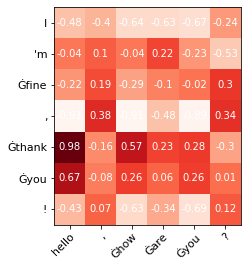

In [5]:
# pre-defined input and output pair
input_str = "hello, how are you?"
output_str = "I'm fine, thank you!"

# find explanation
PM = RandomPM()
perturb_f = PM.perturb_inputs
local_exp  = LERG_S(model_f, input_str, output_str, perturb_f, tokenizer)
phi_set, phi_map, input_segments, output_segments = local_exp.get_local_exp()
fig, ax = plot_interactions(phi_map, input_segments, output_segments)

I'm good, how are you?


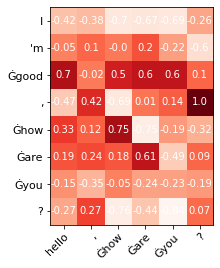

In [6]:
# pre-defined input and the generated output
import transformers
input_str = "hello, how are you?"
input_ids = tokenizer.encode(tokenizer.tokenize(input_str) + [tokenizer.eos_token], return_tensors='pt').to(device)
output_ids = model.generate(input_ids,max_length=20, pad_token_id=tokenizer.eos_token_id)
output_str = tokenizer.decode(output_ids[0][input_ids.shape[1]:],skip_special_tokens=True)
print(output_str)

# find explanation
PM = RandomPM()
perturb_f = PM.perturb_inputs
local_exp  = LERG_S(model_f, input_str, output_str, perturb_f, tokenizer)
phi_set, phi_map, input_segments, output_segments = local_exp.get_local_exp()
fig, ax = plot_interactions(phi_map, input_segments, output_segments)